# Wind field calculations from IBTrACs data

In [1]:
from os.path import join
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

### References
IBTrACs dataset: doi:10.25921/82ty-9e16

### Tasks
- [x] Load IBTrACs data and process for period discrepancies if necessary
- [x] Visualise storm tracks
- [x] Choose radius of maximum wind speed
- [ ] Define AOI and grid
- [ ] Read up on use of haversine distances and Holland (1980) method
- [ ] Implement Holland method over AOI

**Output:** gridded wind direction, speed, and pressure for AOI.

In [2]:
# start with unprocessed Idai IBTrACs data 
indir = join("..", "beira", "indata")
outdir = join("..", "beira", "outdata")

wind_df = pd.read_csv(join(indir, "ibtracs.csv"), header=0)[1:]
wind_df[["WMO WIND", "USA WIND", "REUNION WIND"]].head()

,WMO WIND,USA WIND,REUNION WIND
1,30,NaN,30
2,NaN,NaN,31
3,33,NaN,33
4,NaN,NaN,35
5,37,NaN,37


In [3]:
units_df = pd.read_csv(join(indir, "ibtracs.csv"), header=0)[0:1]
units_df[["LAT", "LON", "WMO WIND", "WMO PRES", "DIST2LAND", "LANDFALL", 'STORM SPEED', 'STORM DIR', 'REUNION RMW']]

,LAT,LON,WMO WIND,WMO PRES,DIST2LAND,LANDFALL,STORM SPEED,STORM DIR,REUNION RMW
0,degrees north,degrees east,kts,mb,km,km,kts,degrees,nmile


1 nautical mile $\approxeq$ 1.1508 land-measured miles $\approxeq$ 1.852 km.


Looking at the dataframe, the maximum wind speed (WMO WIND) is more similar to Reunion than USA recordings so we will use this for the radius of max winds (RMW) later.

In [4]:
wind_df = pd.read_csv(join(indir, "ibtracs.csv"), header=0)[1:]
grid_gdf = gpd.read_file(join(indir, "grid.shp")).to_crs("EPSG:4326")

wind_df = wind_df[["BASIN", "ISO_TIME_________", "LAT", "LON", "WMO WIND", "WMO PRES", "DIST2LAND", "LANDFALL", 'STORM SPEED', 'STORM DIR', 'REUNION RMW']]
wind_df.columns = ["BASIN", "ISO_TIME", "LAT", "LON", "WMO_WIND", "WMO_PRES", "DIST2LAND", "LANDFALL", 'STORM_SPEED', 'STORM_DIR', 'REUNION_RMW']

wind_df = wind_df.dropna(subset="WMO_WIND").reset_index()
for feature in ['WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'LANDFALL', 'REUNION_RMW']:
    wind_df[feature] = wind_df[feature].apply(lambda x: float(x))

wind_gdf = gpd.GeoDataFrame(wind_df, geometry=gpd.points_from_xy(wind_df.LON, wind_df.LAT))
wind_gdf = wind_gdf.set_crs("EPSG:4326")
print("Features:", *wind_df.columns)

Features: index BASIN ISO_TIME LAT LON WMO_WIND WMO_PRES DIST2LAND LANDFALL STORM_SPEED STORM_DIR REUNION_RMW geometry


    coast_gdf = gpd.read_file(join(indir, "osm_processed", "osm_coastline_final.shp"))
    bounding_box = wind_gdf.envelope
    bbox_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

    from shapely.geometry import box
    bbox = box(*wind_gdf.total_bounds)
    
    coast_clipped = coast_gdf.clip(coast_gdf, bbox)  # this takes quite a while
    coast_clipped.plot()

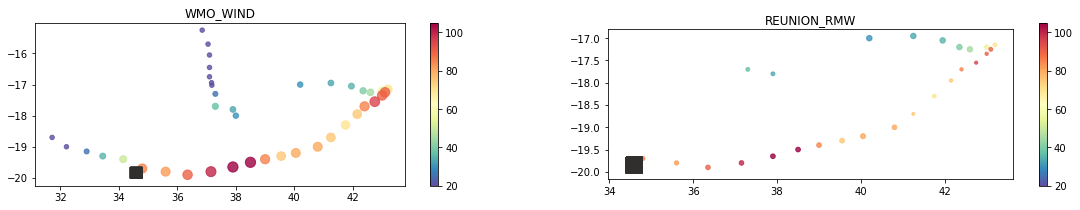

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))

# coast_gdf.plot(ax=ax[0], color="#302f2d")
wind_gdf.plot(column="WMO_WIND", ax=ax[0], cmap="Spectral_r", alpha=0.8,
              markersize="WMO_WIND", legend=True)
grid_gdf.boundary.plot(ax=ax[0], color="#302f2d")
ax[0].set_title("WMO_WIND");

wind_gdf.plot(column="WMO_WIND", ax=ax[1], cmap="Spectral_r", alpha=0.8,
              markersize="REUNION_RMW", legend=True)
grid_gdf.boundary.plot(ax=ax[1], color="#302f2d")
ax[1].set_title("REUNION_RMW");

## Calculate the wind field

In [6]:
def haversine(lon1, lat1, lon2_lst, lat2_lst):
    """Code from J. Verschuur. Haversine distance in km."""
    lon2_arr = np.array(lon2_lst)
    lat2_arr = np.array(lat2_lst)

    # convert degrees to radians
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2_arr = np.deg2rad(lon2_arr)
    lat2_arr = np.deg2rad(lat2_arr)

    # formula
    dlon = lon2_arr - lon1
    dlat = lat2_arr - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2_arr) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r_e = 6371
    return c * r_e

def holland_wind_field(r, wind, pressure, pressure_env, distance, lat):
    """Code from J. Verschuur. Uses different rho to Holland (1980).
    
    Parameters:
    -----------
    r : float
        radius of maximum winds (km).
    wind : float
        wind speed (m / s)
    pressure : float
        central pressure (mb)
    pressure_env : float
        ambient pressure (mb), often taken as value of first anticyclonic isobar
        Holland (1980).
    distance : float
        distance from point to storm centre (km)
    latitude : float
    
    """
    # change distance and radius to meters
    distance = distance * 1000
    r = r * 1000
    rho = 1.10
    f = np.abs(1.45842300 * 10 ** -4 * np.sin(lat))
    e = 2.71828182846
    # p_drop = 2*wind**2
    p_drop = (pressure_env - pressure) * 100
    B = rho * e * wind ** 2 / p_drop
    Vg = (
        np.sqrt(
            ((r / distance) ** B) * (wind ** 2) * np.exp(1 - (r / distance) ** B)
            + (r ** 2) * (f ** 2) / 4
        )
        - (r * f) / 2
    )
    return Vg

In [37]:
centroids = grid_gdf.centroid
wind_tracks = wind_gdf.geometry
lats = [*wind_tracks.y]
lons = [*wind_tracks.x]

h_distances = []
for centroid in centroids:
    h_distances.append(haversine(centroid.x, centroid.y, lons, lats))

h_distances = np.array(h_distances)
assert len(wind_gdf) == h_distances.shape[1]
# each h_distances row represents distances from one grid cell 
# to the storm at one of 40 time stamps

/var/folders/pw/g3l12fr515df7s6dpdch4qx00000gn/T/ipykernel_2071/4199691788.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = grid_gdf.centroid


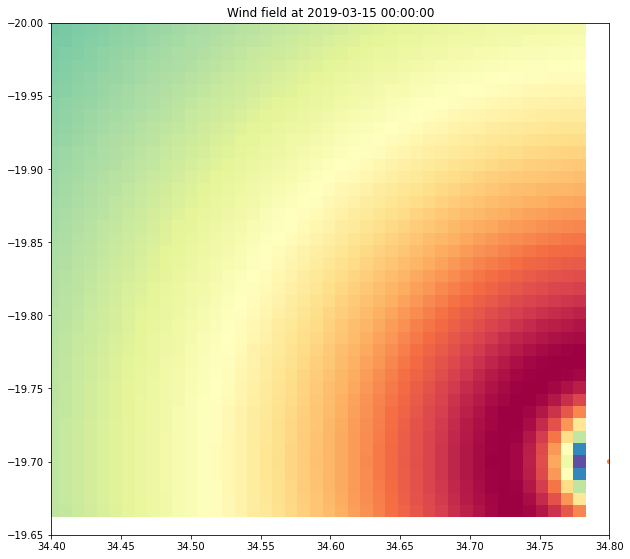

In [46]:
time = 34
iso_time = wind_gdf['ISO_TIME'][time]
h_dists = [x[time] for x in h_distances]
r = wind_gdf["REUNION_RMW"][time] / 1.852  # change nmiles to km
wind = wind_gdf["WMO_WIND"][time] * 0.514444  # change knots to m/s
pressure = wind_gdf["WMO_PRES"][time]
pressure_env = 1010.6  # South Indian Ocean
lat = float(wind_gdf["LAT"][time])

wind_fields = []
for distance in h_dists:
    wind_fields.append(holland_wind_field(r, wind, pressure, pressure_env, distance, lat))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_gdf[f"WIND_{iso_time}"] = [x / 0.514444 for x in wind_fields]
grid_gdf.plot(column=f"WIND_{iso_time}", ax=ax, cmap="Spectral_r", legend=False)
ax.set_title(f"Wind field at {iso_time}");
wind_gdf.plot(column="WMO_WIND", ax=ax, cmap="Spectral_r",
               markersize="REUNION_RMW", legend=False)
ax.set_xlim(34.4, 34.8);
ax.set_ylim(-19.65, -20);

This doesn't look right, it's just linearly decaying but from a much lower wind speed. Also took ambient pressure from South Pacific as in the code Max sent me but need to verify this with ERA5. A bigger issue is the linear decay... this was just because was using index wrong way around. Can use example below with larger grid to view this.

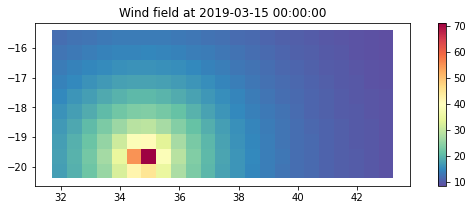

In [35]:
from data_utils import *
grid = make_grid(*wind_gdf.total_bounds, length=0.5, wide=0.5)
grid_lonlat = grid.to_crs("EPSG:4326")

centroids = grid.centroid
wind_tracks = wind_gdf.geometry
lats = [*wind_tracks.y]
lons = [*wind_tracks.x]

h_distances = []
for centroid in centroids:
    h_distances.append(haversine(centroid.x, centroid.y, lons, lats))

h_distances = np.array(h_distances)
assert len(wind_gdf) == h_distances.shape[1]
# each h_distances row represents distances from one grid cell 
# to the storm at one of 40 time stamps

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

time = 34
iso_time = wind_gdf['ISO_TIME'][time]
h_dists = [x[time] for x in h_distances]
r = wind_gdf["REUNION_RMW"][time] / 1.852  # change nmiles to km
wind = wind_gdf["WMO_WIND"][time] * 0.514444  # change knots to m/s
pressure = wind_gdf["WMO_PRES"][time]
pressure_env = 1010.6  # South Indian Ocean
lat = float(wind_gdf["LAT"][time])

wind_fields = []
for distance in h_dists:
    wind_fields.append(holland_wind_field(r, wind, pressure, pressure_env, distance, lat))

grid[f"WIND_{iso_time}"] = [x / 0.514444 for x in wind_fields]
grid.plot(column=f"WIND_{iso_time}", ax=ax, cmap="Spectral_r", legend=True)
ax.set_title(f"Wind field at {iso_time}");
#     wind_gdf.plot(column="WMO_WIND", ax=ax, cmap="Spectral_r",
#                    markersize="REUNION_RMW", legend=True)
